In [37]:
job_name_map = {
    "scrap_measurement_overhead": {
        "id": 694
    },
    "moon": {
        "id": 804, # 3 Clients crashed,
        "dev_order": ["jao1", "jao2", "jon1", "jon2", "jon3", "jon4", "jxn1", "jxn2", "jn5", "jn6"],
        "dev_type_order": ["AGXOrin", "OrinNano", "XavierNX", "Nano"],
        "data_samples": [82, 57, 69, 78, 81, 59, 81, 67, 126, 76],
    },
    "moon_fedprox": {
        "id": 808,
        "data_samples": [82, 57, 69, 78, 81, 59, 81, 67, 126, 76],
    },
    "test": {
        "id": 809
    },
}

In [70]:
import os
from pathlib import Path
import subprocess
from subprocess import CompletedProcess
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
from pandas import DataFrame
import numpy as np

matplotlib.pyplot.ion()
%config InlineBackend.figure_formats = ['svg']
sns.set_theme(style="whitegrid")
# sns.set_theme(style="white")
sns.set_palette("colorblind")

def collect_job_metrics(exp_name, skip_pull_if_dir=True):
    job_id = job_name_map[exp_name]["id"]
    command = ["colext_get_metrics", "-j", str(job_id)]
    output_dir = Path(f"metrics/{exp_name}")

    if os.path.isdir(output_dir) and skip_pull_if_dir:
        return output_dir

    os.makedirs(output_dir, exist_ok=True)
    result: CompletedProcess = subprocess.run(command, capture_output=True, cwd=output_dir)
    if result.returncode != 0:
        print(f"ERROR: Could not collect job metrics for job_id = {job_id}")
        os.rmdir(output_dir)

    return output_dir

def comp_comulative_energy_hw_metrics(group):
    group['delta_t_sec'] = group['time'].diff().dt.total_seconds().fillna(0)
    group['energy'] = (group['power_consumption'] * group['delta_t_sec']).cumsum()
    return group

def reset_network_counts_to_min(group):
    min_index = group['time'].idxmin()

    min_n_bytes_sent = group.loc[min_index, 'n_bytes_sent']
    min_n_bytes_rcvd = group.loc[min_index, 'n_bytes_rcvd']

    group["n_bytes_sent"] -= min_n_bytes_sent
    group["n_bytes_rcvd"] -= min_n_bytes_rcvd
    return group

def collect_power_metrics_client_rounds(cr_metrics, hw_metrics, round_metrics):
    group_cols = ['client_id', 'round_number', 'stage']
    def get_energy(cr_group):
        hw_group = hw_metrics[(hw_metrics[group_cols] == cr_group.name).all(axis=1)]
        # if hw_group empty, we don't have a measurement for that stage
        # happens when evaluate is too fast
        if hw_group.empty:
            cr_group['Energy (J)'] = np.nan
        else:
            hw_group.set_index('time', inplace=True)

            start_i = hw_group.index.get_indexer(cr_group['start_time'], method='nearest')
            end_i = hw_group.index.get_indexer(cr_group['end_time'], method='nearest')
            cr_group['Energy training (J)'] = (float(hw_group.iloc[end_i]['energy'][0]) - float(hw_group.iloc[start_i]['energy'][0])) * 1000 # (KJ -> J)

            _, r_num, stage = cr_group.name
            round_metric_f = round_metrics.query(f"round_number == {r_num} and stage == '{stage}'")
            start_i = hw_group.index.get_indexer(round_metric_f['start_time'], method='nearest')
            end_i = hw_group.index.get_indexer(round_metric_f['end_time'], method='nearest')
            cr_group['Energy in round (J)'] = (float(hw_group.iloc[end_i]['energy'][0]) - float(hw_group.iloc[start_i]['energy'][0])) * 1000 # (KJ -> J)

        return cr_group
    return cr_metrics.groupby(group_cols).apply(get_energy).reset_index(drop=True)

def round_label_hw_metrics(hw_metrics, round_metrics):
    time_bins = round_metrics["start_time"].tolist() + [round_metrics["end_time"].max()]
    labels = round_metrics["round_number"].tolist()
    hw_metrics['round_number'] = pd.cut(hw_metrics['time'], bins=time_bins, labels=labels, right=False, ordered=False)
    labels = round_metrics["stage"].tolist()
    hw_metrics['stage'] = pd.cut(hw_metrics['time'], bins=time_bins, labels=labels, right=False, ordered=False)

    return hw_metrics

def read_job_metrics(exp_name, job_metric_dir):
    job_id = job_name_map[exp_name]["id"]
    path_prefix = f"{job_metric_dir}/colext_{job_id}"

    client_info: DataFrame = pd.read_csv(f"{path_prefix}_client_info.csv").set_index('client_id')
    round_metrics: DataFrame = pd.read_csv(f"{path_prefix}_round_metrics.csv", parse_dates=['start_time', 'end_time'])
    cr_timings: DataFrame = pd.read_csv(f"{path_prefix}_client_round_timings.csv", parse_dates=['start_time', 'end_time'])
    hw_metrics: DataFrame = pd.read_csv(f"{path_prefix}_hw_metrics.csv", parse_dates=['time'])
    hw_metrics["time"] = pd.to_datetime(hw_metrics["time"], format='ISO8601')

    # Cleaning NA values (when clients crash)
    na_ids = cr_timings.isna().any(axis=1)
    print(f"Removing the following entries with Nan values from cr_timings {cr_timings[na_ids]}")
    cr_timings.dropna(inplace=True)

    # Clip HW measurements to start at first round and finish at last round
    start_time = round_metrics["start_time"].min()
    end_time = round_metrics["end_time"].max()
    hw_metrics = hw_metrics[(hw_metrics['time'] > start_time) & (hw_metrics['time'] < end_time)].copy()
    # hw_metrics = hw_metrics.groupby('client_id').apply(reset_network_counts_to_min).reset_index(drop=True)

    # Compute energy from power
    hw_metrics = hw_metrics.groupby('client_id').apply(comp_comulative_energy_hw_metrics).reset_index(drop=True)
    # Add round + stage to hw_metrics
    hw_metrics = round_label_hw_metrics(hw_metrics, round_metrics)

    # Adjust units
    hw_metrics["mem_util"] = hw_metrics["mem_util"] / 1024 / 1024 # MiB
    hw_metrics["power_consumption"] = hw_metrics["power_consumption"] / 1000 # W
    hw_metrics["energy"] = hw_metrics["energy"] / 1000 / 1000 # From mJ -> KJ
    hw_metrics["n_bytes_sent"] = hw_metrics["n_bytes_sent"] / 1024 / 1024   # MiB
    hw_metrics["n_bytes_rcvd"] = hw_metrics["n_bytes_rcvd"] / 1024 / 1024   # MiB
    hw_metrics["net_usage_out"] = hw_metrics["net_usage_out"] / 1024 / 1024 # MiB/s
    hw_metrics["net_usage_in"] =  hw_metrics["net_usage_in"]  / 1024 / 1024 # MiB/s
    # hw_metrics["n_bytes_sent"] = hw_metrics["n_bytes_sent"] / 1024 # KiB
    # hw_metrics["n_bytes_rcvd"] = hw_metrics["n_bytes_rcvd"] / 1024 # KiB
    # hw_metrics["net_usage_out"] = hw_metrics["net_usage_out"] / 1024  # KiB/s
    # hw_metrics["net_usage_in"] =  hw_metrics["net_usage_in"]  / 1024  # KiB/s

    # Compute time deltas for client_rounds
    cr_timings['Training time (s)'] = (cr_timings['end_time'] - cr_timings['start_time']).dt.total_seconds()
    # Get energy per round per client + energy only for client training time
    cr_timings = collect_power_metrics_client_rounds(cr_timings, hw_metrics, round_metrics)
    cr_timings['EDP (J*s)'] = cr_timings['Energy training (J)'] * cr_timings['Training time (s)']

    data_samples = job_name_map[exp_name]["data_samples"]
    cr_timings['Training time ps (s)'] = cr_timings.apply(lambda row: row["Training time (s)"] / data_samples[row["client_id"]], axis=1)
    cr_timings['Energy ps (J)'] = cr_timings.apply(lambda row: row["Energy training (J)"] / data_samples[row["client_id"]], axis=1)
    cr_timings['EDP ps (J*s)'] = cr_timings['Training time ps (s)'] * cr_timings['Energy ps (J)']

    # Add client device name and type
    cr_timings = cr_timings.join(client_info, on="client_id")
    hw_metrics = hw_metrics.join(client_info, on="client_id")

    # Rename columns
    hw_metrics.rename(columns={
        "cpu_util": "CPU Util (%)",
        "gpu_util": "GPU Util (%)",
        "mem_util": "Mem Util (MiB)",
        "power_consumption": "Power (W)",
        "energy": "Energy (KJ)",
        # "n_bytes_sent": "Sent (KiB)",
        # "n_bytes_rcvd": "Rcvd (KiB)",
        # "net_usage_out": "Upload (KiB/s)",
        # "net_usage_in":  "Download (KiB/s)",
        "n_bytes_sent": "Sent (MiB)",
        "n_bytes_rcvd": "Rcvd (MiB)",
        "net_usage_out": "Upload (MiB/s)",
        "net_usage_in":  "Download (MiB/s)",
        }, inplace=True)

    job_data = {}
    job_data["client_info"] = client_info
    job_data["cr_timings"] = cr_timings
    job_data["hw_metrics"] = hw_metrics
    job_data["round_metrics"] = round_metrics
    return job_data

def plot_hw_metrics(df, id_vars="device_type", save_name=None):
    """Convert to long format and print facetgrid with metrics"""
    df_long = pd.melt(df, id_vars=id_vars, var_name='metric')

    g = sns.FacetGrid(df_long, col="metric", hue="device_type", sharex=False, col_wrap=4)
    order=["JetsonAGXOrin", "JetsonOrinNano", "JetsonXavierNX", "JetsonNano", "LattePandaDelta3", "OrangePi5B"]
    g.map(sns.barplot, "value", "device_type", orient="h", order=order)
    g.set_axis_labels("", "")
    g.set_titles("{col_name}")
    if save_name:
        g.figure.savefig(f"plots/{save_name}")
    g.figure.show()

def plot_cir_metrics(df, exp_name, row="device_type", order=None, save_name=None, cols_per_sample=False):
    """Convert to long format and print facetgrid with metrics"""
    id_vars=[row, "stage"]
    cols = [row, "stage"]

    if cols_per_sample:
        cols += ["Training time ps (s)", "Energy ps (J)", 'EDP ps (Normalized)']
    else:
        cols += ["Training time (s)", "Energy training (J)", "Energy in round (J)", 'EDP (Normalized)']

    df = df[cols]
    df_long = pd.melt(df, id_vars=id_vars, var_name='metric')

    if order is None:
        order_field = "dev_order" if row == "device_name" else "dev_type_order"
        order = job_name_map[exp_name].get(order_field)

    # g = sns.FacetGrid(df_long, col="metric", hue=row, sharex='col')
    # g.map(sns.barplot, "value", row, orient="h", order=order)
    g = sns.catplot(x="value", y=row, col="metric", hue=row, data=df_long,
                    kind="bar", order=order, sharex=False, height=3)
    g.set_axis_labels("", "")
    # g.set_titles(col_template="{col_name}", row_template="{row_name}")
    g.set_titles(col_template="{col_name}")
    if save_name:
        g.figure.savefig(f"plots/{save_name}")
    g.figure.show()

def full_algo_plot(cr_timings, exp_name):
    # PS for EVAL part will be wrong so we only do fit
    cr_timings = cr_timings[cr_timings["stage"] == "FIT"]

    # 1 Plot
    # row = "device_type"
    # mean_edp_by_dev_type = cr_timings.groupby(row)['EDP (J*s)'].mean()
    # min_mean_edp = mean_edp_by_dev_type.min()
    # cr_timings['EDP (Normalized)'] = cr_timings.groupby('stage')['EDP (J*s)'].transform(lambda x: x / min_mean_edp)
    # plot_cir_metrics(cr_timings, exp_name, row=row)

    # 2 Plot
    row = "device_name"
    mean_edp_by_dev_name = cr_timings.groupby(row)['EDP (J*s)'].mean()
    min_mean_edp = mean_edp_by_dev_name.min()
    cr_timings['EDP (Normalized)'] = cr_timings.groupby('stage')['EDP (J*s)'].transform(lambda x: x / min_mean_edp)
    plot_cir_metrics(cr_timings, exp_name, row=row)

    # 3 Plot
    row = "device_type"
    mean_edp = cr_timings.groupby(row)['EDP ps (J*s)'].mean()
    min_mean_edp = mean_edp.min()
    cr_timings['EDP ps (Normalized)'] = cr_timings.groupby('client_id')['EDP ps (J*s)'].transform(lambda x: x / min_mean_edp)
    plot_cir_metrics(cr_timings, exp_name, row=row, cols_per_sample=True)

    # 4 Plot
    row = "device_name"
    mean_edp = cr_timings.groupby(row)['EDP ps (J*s)'].mean()
    min_mean_edp = mean_edp.min()
    cr_timings['EDP ps (Normalized)'] = cr_timings.groupby('client_id')['EDP ps (J*s)'].transform(lambda x: x / min_mean_edp)
    plot_cir_metrics(cr_timings, exp_name, row=row, cols_per_sample=True)

In [ ]:
exp_name="scrap_measurement_overhead"
job_metric_dir = collect_job_metrics(exp_name)
job_data = read_job_metrics(exp_name, job_metric_dir)

df = job_data["hw_metrics"][["device_type", "CPU Util (%)", "Mem Util (MiB)", "Power (W)"]]
plot_hw_metrics(df, save_name="scrape_hw_1.pdf")

df = job_data["hw_metrics"][["device_type", "Sent (MiB)", "Rcvd (MiB)", "Upload (MiB/s)", "Download (MiB/s)"]]
# df = job_data["hw_metrics"][["device_type", "Sent (KiB)", "Rcvd (KiB)", "Upload (KiB/s)", "Download (KiB/s)"]]
plot_hw_metrics(df, save_name="scrape_hw_2.pdf")


In [ ]:
exp_name="test"
job_metric_dir = collect_job_metrics(exp_name)
order = ["JetsonAGXOrin", "JetsonOrinNano"]
job_data = read_job_metrics(exp_name, job_metric_dir)
plot_cir_metrics(job_data["cr_timings"], order=order)

In [48]:
exp_name="moon"
job_metric_dir = collect_job_metrics(exp_name)
moon_job_data = read_job_metrics(exp_name, job_metric_dir)

mapping = {
    "JetsonAGXOrin": "AGXOrin",
    "JetsonOrinNano": "OrinNano",
    "JetsonXavierNX": "XavierNX",
    "JetsonNano": "Nano",
}
cr_timings = moon_job_data["cr_timings"]
cr_timings['device_type'] = cr_timings['device_type'].replace(mapping)

/tmp/ipykernel_1968247/569420907.py:87: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  cr_timings: DataFrame = pd.read_csv(f"{path_prefix}_client_round_timings.csv", parse_dates=['start_time', 'end_time'])


Removing the following entries with Nan values from cr_timings      client_id  round_number stage start_time end_time
177          1            78   FIT        NaT      NaT
273          2            74   FIT        NaT      NaT
577          5            76   FIT        NaT      NaT


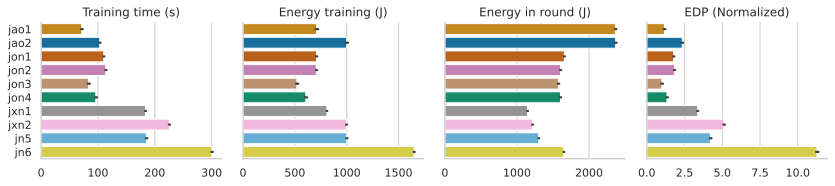

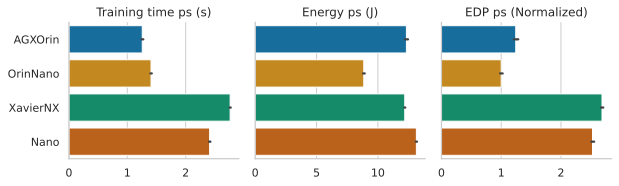

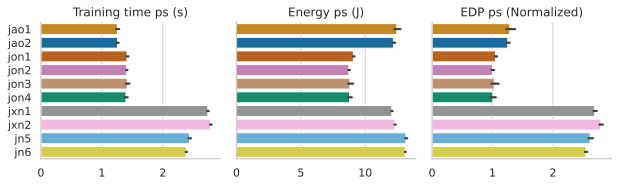

In [49]:
full_algo_plot(moon_job_data["cr_timings"], "moon")

In [50]:
exp_name="moon_fedprox"
job_metric_dir = collect_job_metrics(exp_name)
moon_fedprox_job_data = read_job_metrics(exp_name, job_metric_dir)

Removing the following entries with Nan values from cr_timings Empty DataFrame
Columns: [client_id, round_number, stage, start_time, end_time]
Index: []


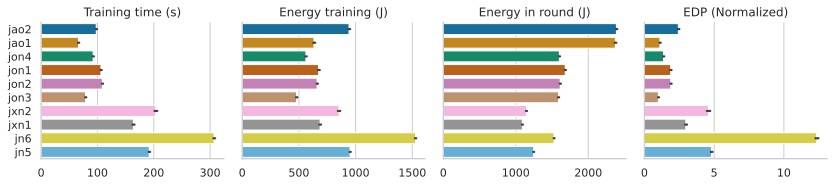

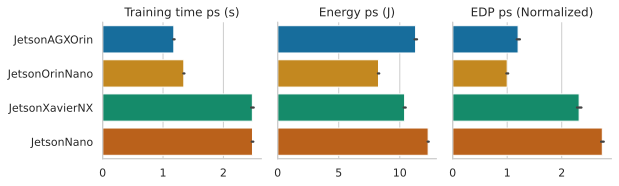

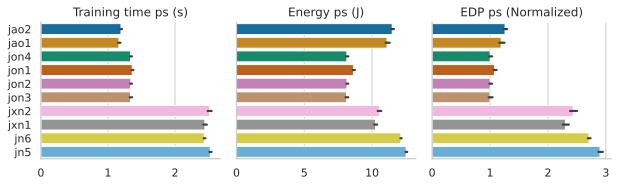

In [51]:
full_algo_plot(moon_fedprox_job_data["cr_timings"], "moon_fedprox")

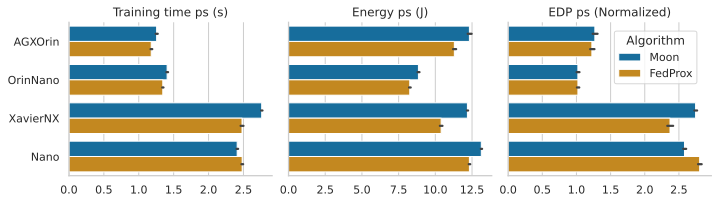

In [156]:
moon_cir_data = moon_job_data["cr_timings"]
moon_cir_data["Algorithm"] = "Moon"

mean_edp = moon_cir_data.groupby('device_name')['EDP ps (J*s)'].mean()
min_mean_edp = mean_edp.min()
moon_cir_data['EDP ps (Normalized)'] = moon_cir_data.groupby('client_id')['EDP ps (J*s)'].transform(lambda x: x / min_mean_edp)

moon_fedprox_data = moon_fedprox_job_data["cr_timings"]
moon_fedprox_data["Algorithm"] = "FedProx"

mapping = {
    "JetsonAGXOrin": "AGXOrin",
    "JetsonOrinNano": "OrinNano",
    "JetsonXavierNX": "XavierNX",
    "JetsonNano": "Nano",
}
moon_fedprox_data['device_type'] = moon_fedprox_data['device_type'].replace(mapping)

mean_edp = moon_fedprox_data.groupby('device_name')['EDP ps (J*s)'].mean()
min_mean_edp = mean_edp.min()
moon_fedprox_data['EDP ps (Normalized)'] = moon_fedprox_data.groupby('client_id')['EDP ps (J*s)'].transform(lambda x: x / min_mean_edp)

# row = 'device_name'
row = "device_type"
df = pd.concat([moon_cir_data, moon_fedprox_data], axis=0, ignore_index=True)
df.dtypes
cols = ["Algorithm", row, "Training time ps (s)", "Energy ps (J)", "EDP ps (Normalized)"]
# cols = ["Algorithm", row, "Training time (s)", "Energy training (J)", "EDP (J*s)"]
df = df[cols]
df_long = pd.melt(df, id_vars=[row, "Algorithm"], var_name='metric')
g = sns.catplot(x="value", y=row, col="metric", hue='Algorithm', data=df_long,
                kind="bar", sharex=False, height=3)
g.set_axis_labels("", "")
g.set_titles(col_template="{col_name}")
sns.move_legend(g, loc="upper right", bbox_to_anchor=(0.97, 0.85), frameon=True)
plt.tight_layout()

In [ ]:

job_data["hw_metrics"].groupby(['client_id', 'round_number', 'stage']).describe()

In [41]:
job_data["hw_metrics"].groupby("device_name").mean(numeric_only=True)

,client_id,CPU Util (%),Mem Util (MiB),GPU Util (%),Power (W),Sent (MiB),Rcvd (MiB),Upload (MiB/s),Download (MiB/s),delta_t_sec,Energy (KJ)
device_name,,,,,,,,,,,
jao1,1.0,5.938010,1021.354482,14.989031,8.539661,0.217983,0.725861,0.008081,0.022612,0.299583,0.473790
jao2,0.0,6.054476,1003.134111,14.966496,8.254389,0.219824,0.718778,0.007040,0.022740,0.299619,0.454875
jon1,3.0,8.382969,1016.610995,29.496943,6.299031,0.291822,0.973631,0.011424,0.038031,0.299818,0.217313
jon4,2.0,9.090909,1005.616039,20.019394,5.657361,0.225645,0.852709,0.008250,0.026895,0.299414,0.267581
